In [36]:
import os
import gc
import re
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE


# Suppress PerformanceWarning
warnings.filterwarnings("ignore")


## Load data

Prior to loading the data generated from running Step 1, we identify and categorize columns with string data types in the dataset. Additionally, it selects columns from the 'V' category, focusing on those that exhibit meaningful relationships with the target variable as revealed through correlation-based exploratory data analysis (EDA). By doing so, the code aims to streamline the dataset to include only the most relevant 'V' columns, optimizing computational efficiency and model performance during subsequent analysis and modeling phases. 

In [37]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# OBTAINED FROM SCRIPT 1
v_cols = ['V1', 'V5', 'V7', 'V8', 'V9', 'V11', 'V13', 'V14', 'V20', 'V24', 'V26', 'V28', 'V30', 
          'V34', 'V36', 'V38', 'V41', 'V45', 'V47', 'V49', 'V52', 'V54', 'V55', 'V56', 'V62', 
          'V65', 'V67', 'V68', 'V70', 'V74', 'V76', 'V78', 'V83', 'V87', 'V88', 'V89', 'V91', 
          'V94', 'V98', 'V100', 'V104', 'V107', 'V109', 'V113', 'V114', 'V116', 'V118', 'V119', 
          'V121', 'V122', 'V124', 'V125', 'V130', 'V131', 'V134', 'V137', 'V281', 'V283', 'V284', 
          'V286', 'V287', 'V289', 'V292', 'V296', 'V297', 'V301', 'V304', 'V305', 'V310', 'V312', 
          'V315', 'V318', 'V321']

cols.extend(v_cols)
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: 
    dtypes[c] = 'category'
    
print('Columns to be read:', cols)

Columns to be read: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V5', 'V7', 'V8', 'V9', 'V11', 'V13', 'V14', 'V20', 'V24', 'V26', 'V28', 'V30', 'V34', 'V36', 'V38', 'V41', 'V45', 'V47', 'V49', 'V52', 'V54', 'V55', 'V56', 'V62', 'V65', 'V67', 'V68', 'V70', 'V74', 'V76', 'V78', 'V83', 'V87', 'V88', 'V89', 'V91', 'V94', 'V98', 'V100', 'V104', 'V107', 'V109', 'V113', 'V114', 'V116', 'V118', 'V119', 'V121', 'V122', 'V124', 'V125', 'V130', 'V131', 'V134', 'V137', 'V281', 'V283', 'V284', 'V286', 'V287', 'V289', 'V292', 'V296', 'V297', 'V301', 'V304', 'V305', 'V310', 'V312', 'V315', 'V318', 'V321']


In [38]:
%%time

# LOAD TRAIN
X_train = pd.read_csv('./train_preprocessed.csv',index_col='TransactionID', dtype=dtypes)
# LOAD TEST
X_test = pd.read_csv('./test_preprocessed.csv',index_col='TransactionID', dtype=dtypes)

# TARGET
y_train = X_train['isFraud'].copy()
del X_train['isFraud']; x = gc.collect()

# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

# DISTRIBUTION OF Y_TRAIN
print(y_train.value_counts())

Train shape (578081, 117) test shape (173242, 117)
isFraud
0    558065
1     20016
Name: count, dtype: int64
CPU times: user 3.1 s, sys: 472 ms, total: 3.57 s
Wall time: 3.73 s


# Normalizing & Converting of D Columns


After looking at the dataset, we realise that the 'D Columns' represent time intervals relative to a specific past reference point. Our objective is to remove time dependence and convert these 'D Columns' into values that correspond to moments in the past rather than future time intervals. This adjustment ensures that the 'D Columns' no longer exhibit an increasing trend over time because we have normalized it against the effects of time. We achieve this transformation using the formula `D15n = Transaction_Day - D15`, where 'Transaction_Day' is calculated as 'TransactionDT' divided by the number of seconds in a day (24 hours * 60 minutes * 60 seconds). Subsequently, we invert the result by multiplying it by -1.

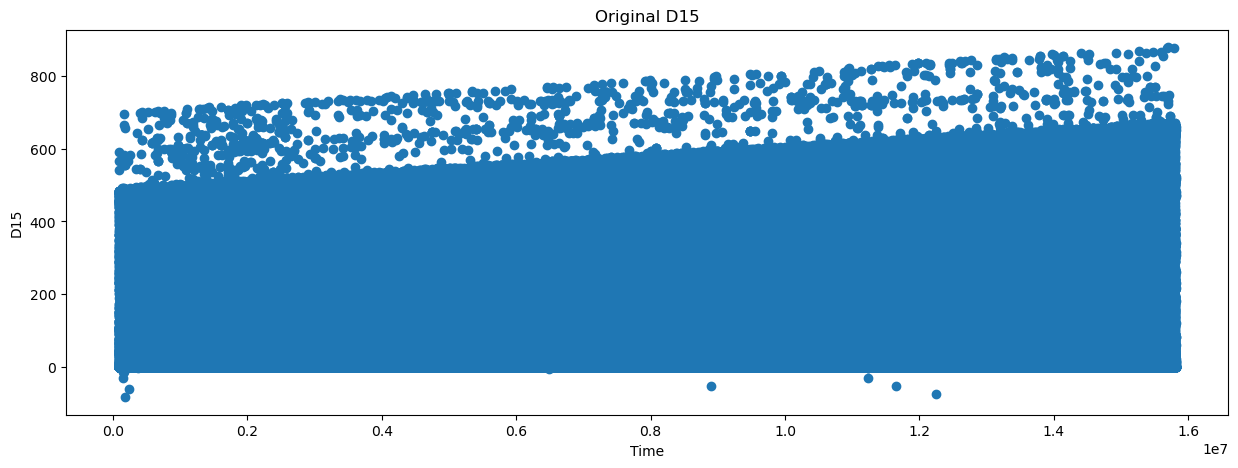

In [39]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

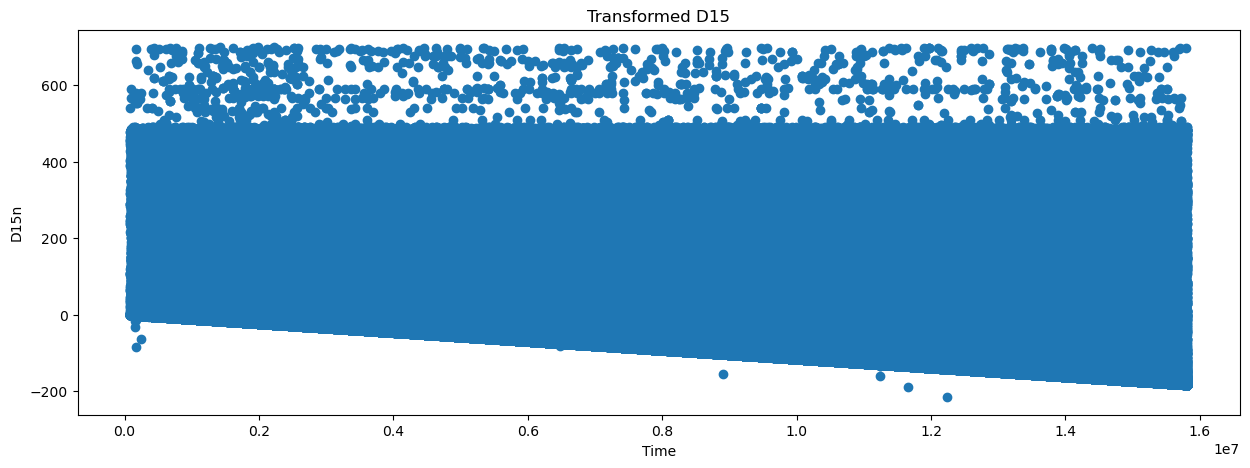

Train shape (578081, 117) test shape (173242, 117)


In [40]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: 
        continue
    # some D columns were dropped in the initial 101 features, so we only preprocess the remaining
    try: 
        X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
        X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 
    except:
        continue
    
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

print('Train shape',X_train.shape,'test shape',X_test.shape)

# More Preprocessing

Our next step involves the transformation of categorical variables to integers through encoding, the normalization of numeric columns, and addressing any missing data. Given the substantial size of the dataset, we also prioritize memory optimization by ensuring the usage of compatible data types wherever possible. This multi-faceted data preprocessing process aims to enhance the dataset's suitability for analysis and modeling, considering both its size and the type of data it contains.

In [41]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i, f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (str(X_train[f].dtype) == 'category') or (X_train[f].dtype == 'object'): 
        df_comb = pd.concat([X_train[f], X_test[f]], axis=0)
        df_comb, _ = df_comb.factorize(sort=True)
        if df_comb.max() > 32000:
            print(f, 'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt', 'TransactionDT']:
        mn = np.min((X_train[f].min(), X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1, inplace=True)
        X_test[f].fillna(-1, inplace=True)

CPU times: user 332 ms, sys: 77.6 ms, total: 410 ms
Wall time: 412 ms


# Encoding Functions

To address categorical variables, we must identify and consider all categorical variables that are present in both the test and train sets. This comprehensive approach ensures that we encode all relevant categorical variables consistently across the entire dataset.

1) `encode_FE` performs frequency encoding after in combines the train and test set. This allows us to see whether the column values are rare or common. For example, we can use this to check which credit cards are used infrequently.

2) `encode_LE` performs label encoding on the categorical features and converts them into integers. We factorize to reduce memory and turn NAN into -1.

3) `encode_AG` creates aggregated features such as the aggregated mean and std dev. This allows for the model to tell if a row has abnormal values compared to the mean value.

4) `encode_CB` combines two columns together into one column.

5) `encode_AG2` creates more aggregated features where it counts how many unique values of one feature within a group.

In [42]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    df1 = df1.copy()
    df2 = df2.copy()
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')
    train_df = train_df.copy()
    test_df = test_df.copy()

# Feature engineering

In this procedure, we brainstorm potential methods to create new features. Subsequently, we assess each newly generated feature's impact on the Area Under the Curve (AUC) metric. If the addition of a feature leads to an increase in AUC, we retain that feature; otherwise, we eliminate it from consideration. This iterative process helps us identify and incorporate features that enhance model performance while disregarding those that do not contribute positively. The below features are the features that we have thought of that increases the AUC score.

In [43]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')

# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])

# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')

# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

# GROUP AGGREGATE
encode_AG(['TransactionAmt','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)
# encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 1.73 s, sys: 364 ms, total: 2.1 s
Wall time: 2.18 s


# Feature selection

Above, we added 23 additional features, bringing the total number of columns to 140, including the index. With this substantial number of features, our goal is to identify the pertinent ones that significantly impact our model's performance. Our chosen evaluation metric is AUC. Therefore, we need to systematically evaluate each feature to ensure that it contributes positively to the model.

Considering that our datasets follow a time sequence, with the test set containing dates that come after the train set, it becomes crucial to ensure that the features exhibit time consistency and remain relevant across different time periods. In this context, the approach to feature selection involves assessing whether a feature maintains its consistency over time independently. Therefore, we will be using time-consistency feature selection. 

While we have explored alternative methods for feature selection, including L1 Regression, Filter methods, and Wrapper methods, our testing has revealed that time-consistency feature selection consistently produces superior results, yielding the highest AUC in our context, be it for local validation or for K-folds, which will be elaborated on in the following sections.

We will be using data from the first 30 days as train data to train the model, and use data from the last 30 days as test data to test the model. Specifically, we want to confirm that each feature yields an AUC score > 0.5 to be considered valuable, if not the feature is not useful as it is worse than random guessing which yields an AUC score of 0.5. Features failing to meet this criterion are considered non-contributory and will be excluded from further consideration.

In [44]:
# Define the start and end timestamps for the first and last months, assuming 30 days in a month
start_timestamp_first_month = X_train['TransactionDT'].min()
end_timestamp_first_month = start_timestamp_first_month + (30 * 24 * 60 * 60)  

start_timestamp_last_month = X_train['TransactionDT'].max() - (30 * 24 * 60 * 60)  
end_timestamp_last_month = X_train['TransactionDT'].max()

# Select rows corresponding to the first month
X_first_month = X_train[(X_train['TransactionDT'] >= start_timestamp_first_month) &
                         (X_train['TransactionDT'] < end_timestamp_first_month)]

# Select rows corresponding to the last month
X_last_month = X_train[(X_train['TransactionDT'] >= start_timestamp_last_month) &
                        (X_train['TransactionDT'] <= end_timestamp_last_month)]

# Extract the indices of rows in X_train that belong to the first month
indices_first_month = (X_train['TransactionDT'] >= start_timestamp_first_month) & (X_train['TransactionDT'] < end_timestamp_first_month)

# Extract the indices of rows in X_train that belong to the last month
indices_last_month = (X_train['TransactionDT'] >= start_timestamp_last_month) & (X_train['TransactionDT'] <= end_timestamp_last_month)

# Use the indices to extract the corresponding y_train entries
y_first_month = y_train[indices_first_month]
y_last_month = y_train[indices_last_month]

In [45]:
%%time
# Create an empty list to store the selected features
selected_features = []

# Define the evaluation threshold (AUC > 0.5)
threshold = 0.5

# Create a tqdm progress bar for the loop
for feature in tqdm(X_train.columns, desc="Processing Features"):
    
    # Train a logistic regression model using only the current feature
    #model = xgb.XGBClassifier()
    model = lgb.LGBMClassifier(verbose=-1)
    model.fit(X_first_month[[feature]], y_first_month)
    
    # Predict on the last month of the training data
    y_pred = model.predict_proba(X_last_month[[feature]])[:, 1]
    
    # Calculate AUC for the validation set
    auc = roc_auc_score(y_last_month, y_pred)
    
    # Check if AUC is above the threshold
    if auc > threshold:
        selected_features.append(feature)

Processing Features: 100%|█████████████████████████████████████████████| 139/139 [00:41<00:00,  3.36it/s]

CPU times: user 4min 11s, sys: 42 s, total: 4min 53s
Wall time: 41.4 s


In [46]:
print('Following',len(X_train.columns) - len(selected_features),'features removed:')
print(np.array(set(X_train.columns) - set(selected_features)))
print('#'*70)
print('Following',len(selected_features),'features selected:')
print(np.array(selected_features))

Following 16 features removed:
{'V286', 'V104', 'V310', 'V107', 'V1', 'V297', 'M3', 'TransactionDT', 'V289', 'V7', 'V305', 'M1', 'addr2', 'card4', 'V9', 'M2'}
######################################################################
Following 123 features selected:
['TransactionAmt' 'ProductCD' 'card1' 'card2' 'card3' 'card5' 'card6'
 'addr1' 'dist1' 'P_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D10' 'D11'
 'D15' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V5' 'V8' 'V11' 'V13' 'V14' 'V20'
 'V24' 'V26' 'V28' 'V30' 'V34' 'V36' 'V38' 'V41' 'V45' 'V47' 'V49' 'V52'
 'V54' 'V55' 'V56' 'V62' 'V65' 'V67' 'V68' 'V70' 'V74' 'V76' 'V78' 'V83'
 'V87' 'V88' 'V89' 'V91' 'V94' 'V98' 'V100' 'V109' 'V113' 'V114' 'V116'
 'V118' 'V119' 'V121' 'V122' 'V124' 'V125' 'V130' 'V131' 'V134' 'V137'
 'V281' 'V283' 'V284' 'V287' 'V292' 'V296' 'V301' 'V304' 'V312' 'V315'
 'V318' 'V321' 'cents' 'addr1_FE' 'card1_FE' 'card2_FE' 'card3_FE'
 'P_emaildomain_FE' 'ca

## Local validation 

We conduct a train-test split, where our model is trained on the first 75% of the dataset and assessed on the remaining 25%. In our local validation, the model achieved an AUC of 0.9305. 

In [47]:
# train split local validation
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [48]:
%%time

# lgboost
print("LGBoost version:", lgb.__version__)

# We add the imbalance ratio for our scale_pos_weight
imbalance_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print('Class imbalanace ratio:', round(imbalance_ratio,4))

clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=1000,
    max_depth=12,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.4,
    metric='auc',
    n_jobs=8,
    random_state=42
)
# Create the log_evaluation callback
callbacks = [
    lgb.early_stopping(100),
    lgb.callback.log_evaluation(period=100)  # Add this callback for verbosity
]

# Splitting dataset before applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.loc[idxT, selected_features], y_train.loc[idxT])
X_valid_resampled, y_valid_resampled = smote.fit_resample(X_train.loc[idxV, selected_features], y_train.loc[idxV])

# Fit the model with callbacks
h = clf.fit(
    X_train_resampled,y_train_resampled,
    eval_set=[(X_valid_resampled, y_valid_resampled)],
    callbacks=callbacks  # Use the callbacks argument for controlling verbosity
)

# Predict probabilities for the positive class (class 1)
y_pred_proba = clf.predict_proba(X_valid_resampled)[:, 1]
pred_threshold = 0.3

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (y_pred_proba >= pred_threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_valid_resampled, y_pred)
precision = precision_score(y_valid_resampled, y_pred)
recall = recall_score(y_valid_resampled, y_pred)
f1 = f1_score(y_valid_resampled, y_pred)
roc_auc = roc_auc_score(y_valid_resampled, y_pred_proba)
confusion = confusion_matrix(y_valid_resampled, y_pred)

# Print the evaluation metrics and confusion matrix
print('ROC AUC Score:', roc_auc,'\n')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#'*20,'\n')

LGBoost version: 3.3.5
Class imbalanace ratio: 27.8809
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.974187
[200]	valid_0's auc: 0.982751
[300]	valid_0's auc: 0.987417
[400]	valid_0's auc: 0.990009
[500]	valid_0's auc: 0.991293
[600]	valid_0's auc: 0.992066
[700]	valid_0's auc: 0.992658
[800]	valid_0's auc: 0.993133
[900]	valid_0's auc: 0.99345
[1000]	valid_0's auc: 0.993722
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.993725
ROC AUC Score: 0.9937249966992028 

Accuracy: 0.9681127842721272
Precision: 0.9767579365369033
Recall: 0.9590461787662249
F1 Score: 0.9678210302477975
Confusion Matrix:
[[136339   3184]
 [  5714 133809]]
#################### 

CPU times: user 8min 45s, sys: 1min 1s, total: 9min 47s
Wall time: 1min 27s


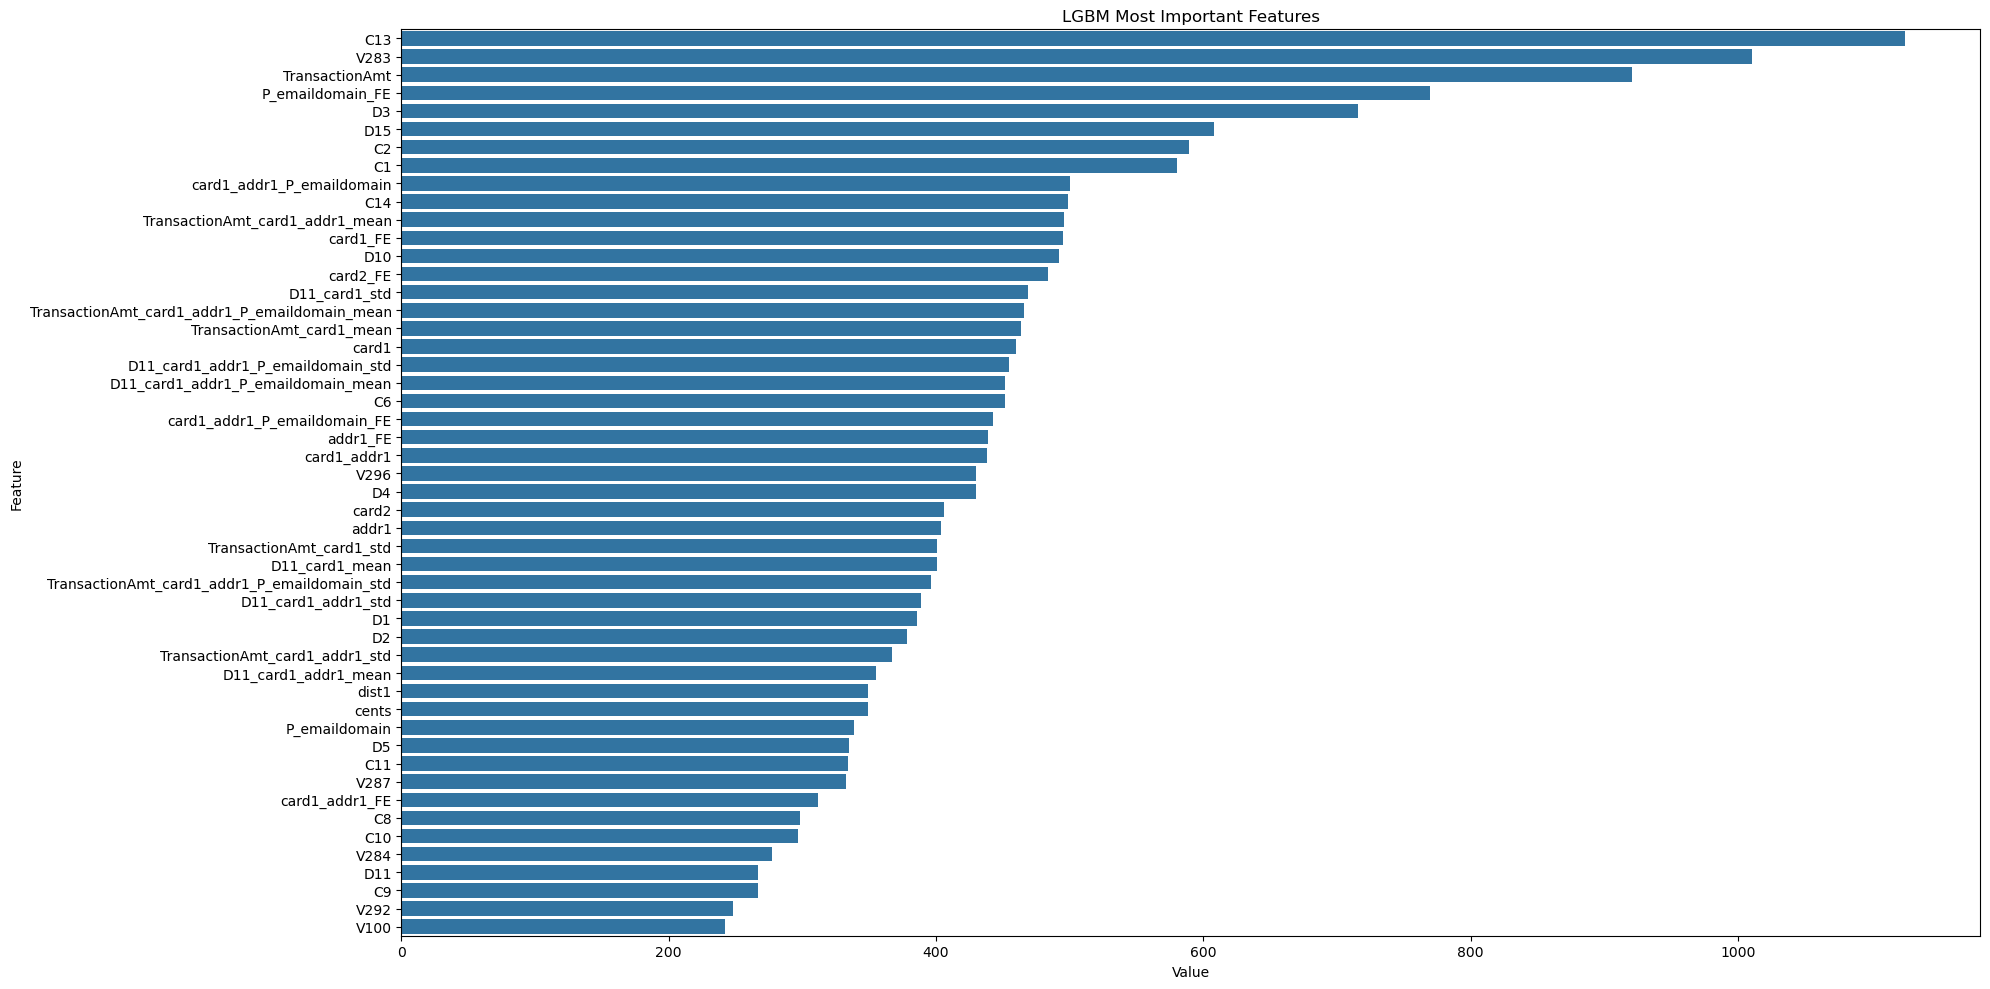

In [49]:
# Create a DataFrame to store feature importances
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,selected_features)), columns=['Value','Feature'])

# Create a figure for the barplot
plt.figure(figsize=(20, 10))

# Create a barplot of the top 50 most important features
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])

# Set the title and adjust layout
plt.title('LGBM Most Important Features')
plt.tight_layout()

# Display the plot
plt.show()

# Clean up and free memory
del clf, h; x = gc.collect()

## Predicting test.csv

Upon examining and converting the training data to datetime format, we determined that the starting date is '2017-11-30.' The training data spans from December 2017 to May 2018, corresponding to months 12, 13, 14, 15, 16, and 17. Here, we refer to December 2017 as month 12.

We employ a 6-fold cross-validation strategy, where each fold represents one of the six months in our dataset. In each fold, we utilize 5 months of historical data for training while reserving one month as a validation set. The model is trained on this 5-month training data and is employed to make predictions for the withheld month. The primary purpose of this withheld month is to act as a signal for early stopping during the model training phase; it is not used for actual predictions for our test.csv.

Let's take the first fold, 'fold 0' as an example. In 'fold 0,' our setup involves training the model on data from months 13, 14, 15, 16, and 17, while excluding data from month 12 in the training set. It's essential to emphasize that the excluded month, 'month 12,' has a specialized role — it serves as a trigger for early stopping during the model training process and is not involved in generating actual predictions. This trained model will then use data from months 13, 14, 15, 16, and 17 to predict the isFraud value for the test.csv dataset. The predicted values for test.csv are then added to the predictions array. The OOF prediction values for month 12 are also stored so as to cross-validate against the actual isFraud values for month 12.

We then move on to the second fold, "fold 1", which involves training the model on data from months 12, 13, 14, 16, and 17, while excluding data from month 15 in the training set. Once again, the excluded month, 'month 15,' serves as a trigger for early stopping during the model training process and is not involved in generating actual predictions. This trained model will then use data from months 12, 13, 14, 16, and 17 to predict the isFraud value for the test.csv dataset. The predicted values for test.csv are then added to the predictions array. The OOF prediction values for month 15 are also stored so as to cross-validate against the actual isFraud values for month 15.

After completing the K-fold cross-validation, we consolidate the six sets of predictions generated from the six K-folds for the 'test.csv' dataset. This consolidation involves taking the average of these predictions, achieved by summing them up and then dividing the total by 6. Consequently, we obtain predicted 'isFraud' values that now range from 0 to 1, representing decimal values. Similarly, OOF prediction values have now been consolidated from all the months in our dataset, creating a complete set of predictions.

Due to XGB's significantly slower performance and high computational demands (LGB took 17 minutes, whereas XGB took 16 hours), we have opted to transition to LGB for the remainder of this notebook's testing phase. LGB offers a slightly lower but still outstanding accuracy, registering an AUC score of 0.9337.


In [50]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 
X_train_og = X_train.copy()
y_train_og = y_train.copy()

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 
X_test_og = X_test.copy()


In [51]:
# Create SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('Original train shape:', X_train.shape, 'Resampled train shape:', X_train_resampled.shape)

X_train = X_train_resampled
y_train = y_train_resampled
del X_train_resampled, y_train_resampled; x = gc.collect()

Original train shape: (578081, 140) Resampled train shape: (1116130, 140)


In [52]:
%%time

# lgboost
# Store out of fold predictions and test set predictions
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

# Setup cross-validation using GroupKFold method
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold', i, 'withholding month', month)
    print('Rows of train =', len(idxT), 'rows of holdout =', len(idxV))

    # Create the LightGBM classifier
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt',
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        metric='auc',
        n_jobs=8,
        random_state=42
    )

    # Create the log_evaluation callback
    callbacks = [
        lgb.early_stopping(100),
        lgb.callback.log_evaluation(period=100)
    ]

    # Fit the model with callbacks
    h = clf.fit(X_train[selected_features].iloc[idxT], y_train.iloc[idxT],
                eval_set=[(X_train[selected_features].iloc[idxV], y_train.iloc[idxV])],
                callbacks=callbacks)

    best_iteration = clf.best_iteration_  # Get the best iteration
    print("Best Iteration:", best_iteration)

    oof[idxV] += clf.predict_proba(X_train[selected_features].iloc[idxV])[:, 1]
    preds += clf.predict_proba(X_test[selected_features])[:, 1] / skf.n_splits
    del h, clf; x = gc.collect()

print('#' * 30)
print('LGBM out of fold cross validation =', roc_auc_score(y_train, oof))

Fold 0 withholding month 12
Rows of train = 888140 rows of holdout = 227990
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.985291
[200]	valid_0's auc: 0.990777
[300]	valid_0's auc: 0.9927
[400]	valid_0's auc: 0.993595
[500]	valid_0's auc: 0.994115
[600]	valid_0's auc: 0.994388
[700]	valid_0's auc: 0.994545
[800]	valid_0's auc: 0.994665
[900]	valid_0's auc: 0.9947
[1000]	valid_0's auc: 0.99477
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.994772
Best Iteration: 995
Fold 1 withholding month 15
Rows of train = 908900 rows of holdout = 207230
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.989069
[200]	valid_0's auc: 0.992118
[300]	valid_0's auc: 0.993612
[400]	valid_0's auc: 0.994514
[500]	valid_0's auc: 0.995089
[600]	valid_0's auc: 0.995468
[700]	valid_0's auc: 0.995794
[800]	valid_0's auc: 0.996046
[900]	valid_0's auc: 0.996212
[1000]	valid_0's auc: 0.996344
Did not meet early stopping. 

In [53]:
# Calculate metrics
pred_threshold = 0.3

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (oof >= pred_threshold).astype(int)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred)
confusion = confusion_matrix(y_train, y_pred)

# Print the evaluation metrics and confusion matrix
print('LGBM out of fold cross validation =', roc_auc_score(y_train, oof))
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#'*20,'\n')

LGBM out of fold cross validation = 0.9959918909882386
Accuracy: 0.9782695564136794
Precision: 0.9832889407154847
Recall: 0.973076612939353
F1 Score: 0.978156122392001
Confusion Matrix:
[[548836   9229]
 [ 15025 543040]]
#################### 



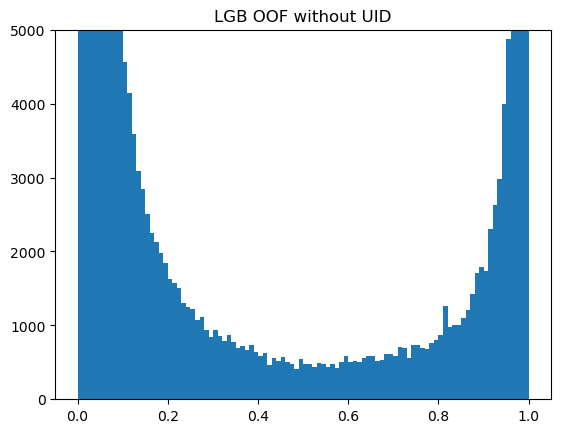

In [54]:
plt.hist(oof,bins=100)
plt.ylim((0,5000))
plt.title('LGB OOF without UID')
plt.show()

# Improvement : Adding of userID(UID) to datasets

Due to the dataset's inherent characteristics, wherein once a client's credit card is associated with fraud, all the transactions within their entire account is categorised as fraud. Thus, this makes it imperative to perform essential preprocessing to identify distinct clients. Failing to do so would lead to inaccurate predictions of fraudulent transactions, as not all transactions flagged as fraud are necessarily fraudulent. Hence, in the following step, to improve our model, we will be creating UID which will allow us to identify clients using the columns card_1, addr_1 and D1.

The UID we've generated isn't flawless, as it includes 3118 UIDs containing both fraudulent and non-fraudulent transactions, which encompasses about 1.4% of all the UIDs generated. This suggests the presence of multiple clients within certain UIDs, though this is a relatively small occurrence within our dataset. However, given that we employ LGB, a tree-based model, it possesses the capability to split and partition its feature space to accommodate this variation. Consequently, our model can effectively separate these UIDs and identify individual clients within them.

Understanding our data: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

In [55]:
X_train = X_train_og.copy()
y_train = y_train_og.copy()
X_test = X_test_og.copy()
del X_train_og, y_train_og, X_test_og;

In [56]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)


In [57]:
# Check for number of UIDs that contain more than one client inside
df = pd.concat([X_train, y_train], axis=1)
x = df.groupby('uid')['isFraud'].apply(lambda x: x.nunique() == 1)
false_entries = x[~x]

print('Total number of UIDs generated:', len(x))
print('Number of UIDs with more than one client inside:', len(false_entries))
print('Percent of bad UIDs:', round(len(false_entries)/len(x)*100,4),'%')

del df,x; x=gc.collect()

Total number of UIDs generated: 212608
Number of UIDs with more than one client inside: 3073
Percent of bad UIDs: 1.4454 %


## Group aggregated features

To incorporate the UID into our model, we must generate certain aggregated group features. However, once we've created these aggregated features, we exclude the UID from our model. This is because the UID, much like the transactionID, doesn't contribute to the model's predictive capabilities.

In [58]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D10','D15'],['uid'],['mean','std'],train_df=X_train, test_df=X_test, fillna=True,usena=True)
# encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],train_df=X_train, test_df=X_test, fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],train_df=X_train, test_df=X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],train_df=X_train, test_df=X_test, fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','cents'], ['uid'], train_df=X_train, test_df=X_test)
# encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],train_df=X_train, test_df=X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V134','V137','V312','V315','V318','V321'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V134_ct, uid_V137_ct, uid_V312_ct, uid_V315_ct, uid_V318_ct, uid_V321_ct, outsider15
CPU times: user 21.4 s, sys: 704 ms, total: 22.1 s
Wall time: 22.2 s


## Feature selection

We perform feature selection again on the dataset as we did before.

In [59]:
# Define the start and end timestamps for the first and last months, assuming 30 days in a month
start_timestamp_first_month = X_train['TransactionDT'].min()
end_timestamp_first_month = start_timestamp_first_month + (30 * 24 * 60 * 60)  

start_timestamp_last_month = X_train['TransactionDT'].max() - (30 * 24 * 60 * 60)  
end_timestamp_last_month = X_train['TransactionDT'].max()

# Select rows corresponding to the first month
X_first_month = X_train[(X_train['TransactionDT'] >= start_timestamp_first_month) &
                         (X_train['TransactionDT'] < end_timestamp_first_month)]

# Select rows corresponding to the last month
X_last_month = X_train[(X_train['TransactionDT'] >= start_timestamp_last_month) &
                        (X_train['TransactionDT'] <= end_timestamp_last_month)]

# Extract the indices of rows in X_train that belong to the first month
indices_first_month = (X_train['TransactionDT'] >= start_timestamp_first_month) & (X_train['TransactionDT'] < end_timestamp_first_month)

# Extract the indices of rows in X_train that belong to the last month
indices_last_month = (X_train['TransactionDT'] >= start_timestamp_last_month) & (X_train['TransactionDT'] <= end_timestamp_last_month)

# Use the indices to extract the corresponding y_train entries
y_first_month = y_train[indices_first_month]
y_last_month = y_train[indices_last_month]

In [60]:
%%time
# Create an empty list to store the selected features
selected_features = []

# Define the evaluation threshold (AUC > 0.5)
threshold = 0.5
X_train = X_train.drop('uid', axis=1)

# Create a tqdm progress bar for the loop
for feature in tqdm(X_train.columns, desc="Processing Features"):
    
    # Train a logistic regression model using only the current feature
    #model = xgb.XGBClassifier()
    model = lgb.LGBMClassifier(verbose=-1)
    model.fit(X_first_month[[feature]], y_first_month)
    
    # Predict on the last month of the training data
    y_pred = model.predict_proba(X_last_month[[feature]])[:, 1]
    
    # Calculate AUC for the validation set
    auc = roc_auc_score(y_last_month, y_pred)
    
    # Check if AUC is above the threshold
    if auc > threshold:
        selected_features.append(feature)

Processing Features: 100%|█████████████████████████████████████████████| 185/185 [00:56<00:00,  3.30it/s]

CPU times: user 5min 42s, sys: 1min 2s, total: 6min 45s
Wall time: 56.2 s


In [61]:
print('Following',len(X_train.columns) - len(selected_features),'features removed:')
print(np.array(set(X_train.columns) - set(selected_features)))
print('#'*70)
print('Following',len(selected_features),'features selected:')
print(np.array(selected_features))

Following 21 features removed:
{'V286', 'V104', 'V107', 'DT_M', 'V7', 'addr2', 'M1_uid_mean', 'M3', 'V289', 'M2', 'D4_uid_mean', 'V297', 'TransactionDT', 'card4', 'day', 'V310', 'V1', 'outsider15', 'V305', 'M1', 'V9'}
######################################################################
Following 164 features selected:
['TransactionAmt' 'ProductCD' 'card1' 'card2' 'card3' 'card5' 'card6'
 'addr1' 'dist1' 'P_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D10' 'D11'
 'D15' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V5' 'V8' 'V11' 'V13' 'V14' 'V20'
 'V24' 'V26' 'V28' 'V30' 'V34' 'V36' 'V38' 'V41' 'V45' 'V47' 'V49' 'V52'
 'V54' 'V55' 'V56' 'V62' 'V65' 'V67' 'V68' 'V70' 'V74' 'V76' 'V78' 'V83'
 'V87' 'V88' 'V89' 'V91' 'V94' 'V98' 'V100' 'V109' 'V113' 'V114' 'V116'
 'V118' 'V119' 'V121' 'V122' 'V124' 'V125' 'V130' 'V131' 'V134' 'V137'
 'V281' 'V283' 'V284' 'V287' 'V292' 'V296' 'V301' 'V304' 'V312' 'V315'
 'V318' 'V321' 'cents' 'addr1_F

## Local validation 

Once again, we perform local validation as in the code above. 

We use train test split by training on first 75% of the train data and predicting 25% of the train data.  Due to XGB's significantly slower performance and high computational demands (LGB took 17 minutes, whereas XGB took 16 hours), we have opted to transition to LGB for the remainder of this notebook's testing phase.

Local validation for LGB with UID achieved an impressive accuracy of 0.9444, surpassing the accuracy of local validation for LGB without UID which is 0.9305. Additionally, an analysis of the most important features in the LGB classifier revealed that seven of the top eight features are in fact the new aggregated features associated with UID.

In [62]:
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [63]:
%%time

# lgboost
print("LGBoost version:", lgb.__version__)

# We add the imbalance ratio for our scale_pos_weight
imbalance_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print('Class imbalanace ratio:', round(imbalance_ratio,4))

clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=1000,
    max_depth=12,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.4,
    metric='auc',
    n_jobs=8,
    random_state=42
)
# Create the log_evaluation callback
callbacks = [
    lgb.early_stopping(100),
    lgb.callback.log_evaluation(period=100)  # Add this callback for verbosity
]

# Splitting dataset before applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.loc[idxT, selected_features], y_train.loc[idxT])
X_valid_resampled, y_valid_resampled = smote.fit_resample(X_train.loc[idxV, selected_features], y_train.loc[idxV])

# Fit the model with callbacks
h = clf.fit(
    X_train_resampled,y_train_resampled,
    eval_set=[(X_valid_resampled, y_valid_resampled)],
    callbacks=callbacks  # Use the callbacks argument for controlling verbosity
)

# Predict probabilities for the positive class (class 1)
y_pred_proba = clf.predict_proba(X_valid_resampled)[:, 1]
pred_threshold = 0.3

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (y_pred_proba >= pred_threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_valid_resampled, y_pred)
precision = precision_score(y_valid_resampled, y_pred)
recall = recall_score(y_valid_resampled, y_pred)
f1 = f1_score(y_valid_resampled, y_pred)
roc_auc = roc_auc_score(y_valid_resampled, y_pred_proba)
confusion = confusion_matrix(y_valid_resampled, y_pred)

# Print the evaluation metrics and confusion matrix
print('ROC AUC Score:', roc_auc,'\n')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#'*20,'\n')

LGBoost version: 3.3.5
Class imbalanace ratio: 27.8809
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.975432
[200]	valid_0's auc: 0.984514
[300]	valid_0's auc: 0.989592
[400]	valid_0's auc: 0.992023
[500]	valid_0's auc: 0.993301
[600]	valid_0's auc: 0.994131
[700]	valid_0's auc: 0.994564
[800]	valid_0's auc: 0.994859
[900]	valid_0's auc: 0.995114
[1000]	valid_0's auc: 0.995289
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.995289
ROC AUC Score: 0.9952891417155306 

Accuracy: 0.9740437060556324
Precision: 0.9799291788813747
Recall: 0.9679121005138938
F1 Score: 0.9738835704112355
Confusion Matrix:
[[136757   2766]
 [  4477 135046]]
#################### 

CPU times: user 11min 7s, sys: 1min 13s, total: 12min 20s
Wall time: 1min 53s


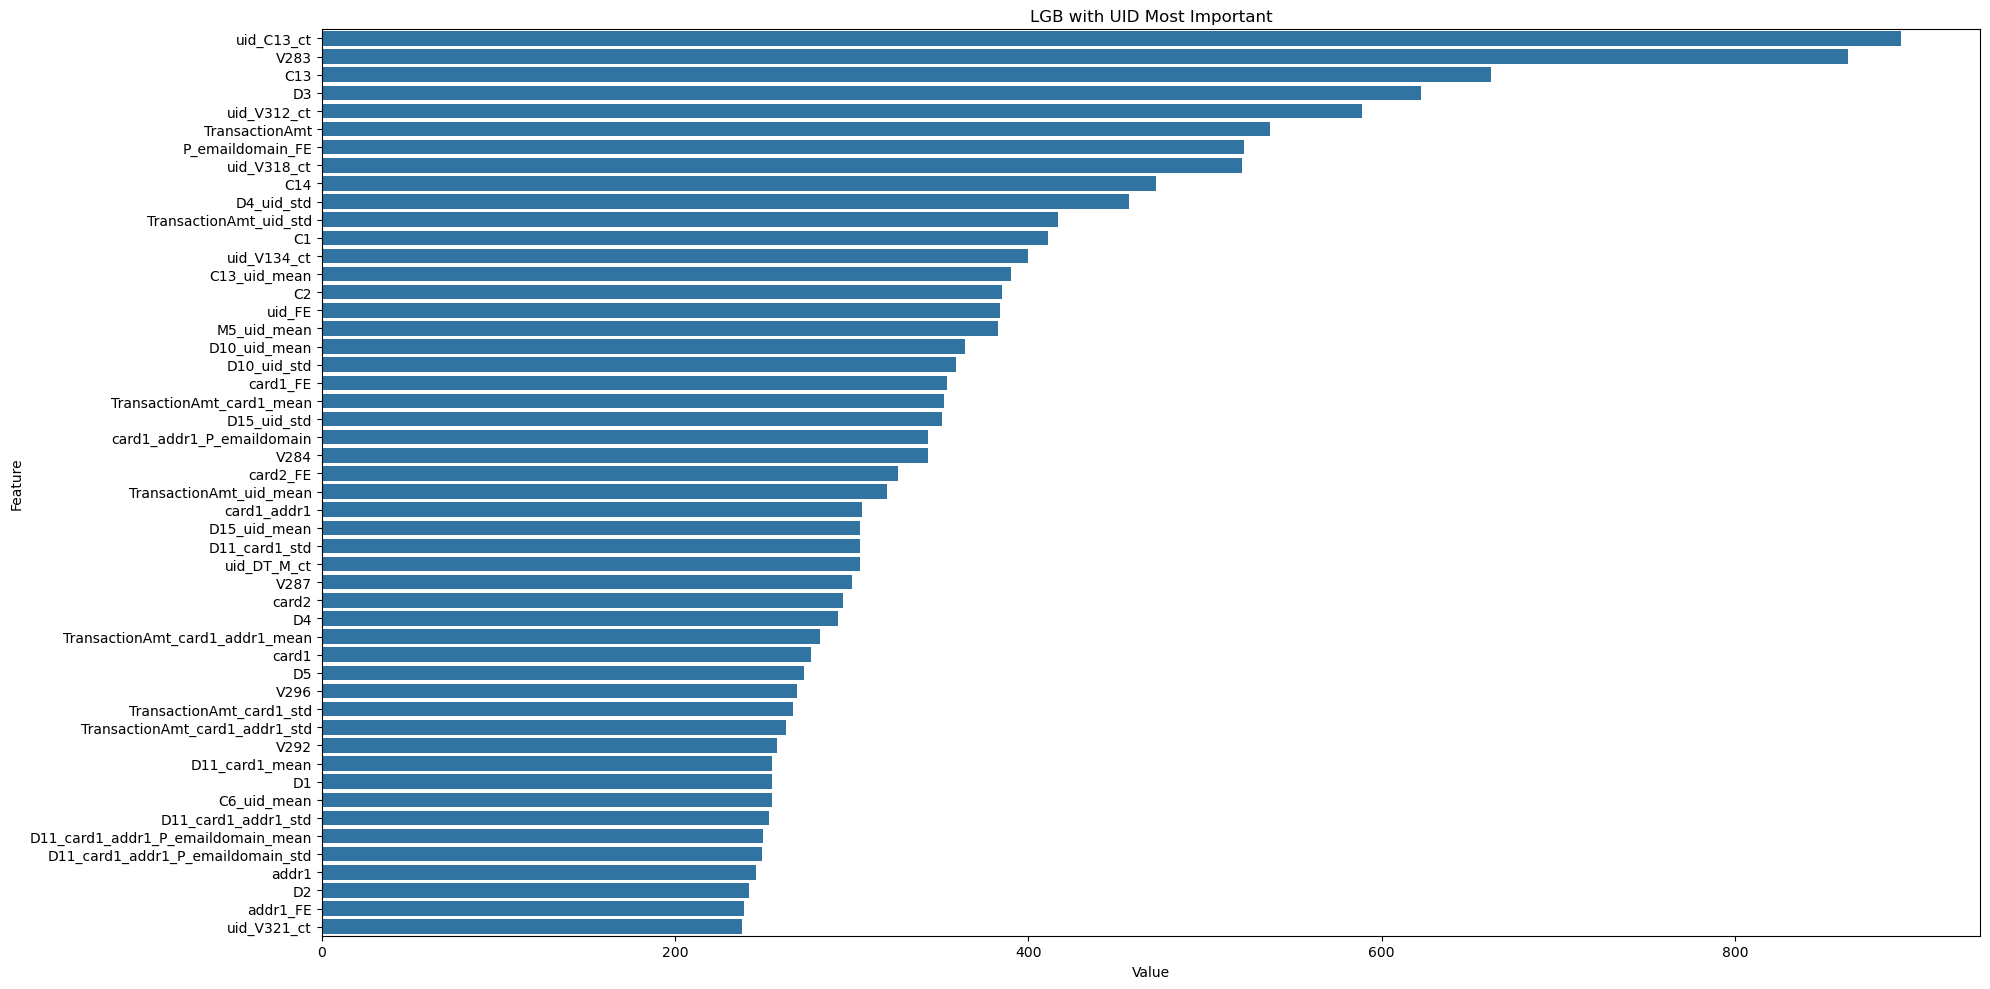

In [64]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,selected_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('LGB with UID Most Important')
plt.tight_layout()
plt.show()

## Predicting test.csv with UID aggregated colums included

LGB with UID achieved an impressive accuracy of 0.9522, surpassing the accuracy of LGB without UID which is 0.9351.

In [65]:
# Create SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('Original train shape:', X_train.shape, 'Resampled train shape:', X_train_resampled.shape)

X_train = X_train_resampled
y_train = y_train_resampled
del X_train_resampled, y_train_resampled; x = gc.collect()

Original train shape: (578081, 185) Resampled train shape: (1116130, 185)


In [66]:
%%time

# lgboost
# Store out of fold predictions and test set predictions
lgb_oof = np.zeros(len(X_train))
lgb_preds = np.zeros(len(X_test))

# Setup cross-validation using GroupKFold method
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold', i, 'withholding month', month)
    print('Rows of train =', len(idxT), 'rows of holdout =', len(idxV))

    # Create the LightGBM classifier
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt',
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        metric='auc',
        n_jobs=8,
        random_state=42
    )

    # Create the log_evaluation callback
    callbacks = [
        lgb.early_stopping(100),
        lgb.callback.log_evaluation(period=100)
    ]

    # Fit the model with callbacks
    h = clf.fit(X_train[selected_features].iloc[idxT], y_train.iloc[idxT],
                eval_set=[(X_train[selected_features].iloc[idxV], y_train.iloc[idxV])],
                callbacks=callbacks)

    best_iteration = clf.best_iteration_  # Get the best iteration
    print("Best Iteration:", best_iteration)

    lgb_oof[idxV] += clf.predict_proba(X_train[selected_features].iloc[idxV])[:, 1]
    lgb_preds += clf.predict_proba(X_test[selected_features])[:, 1] / skf.n_splits
    del h, clf; x = gc.collect()

print('#' * 30)
print('LGBM with UID out of fold cross validation =', roc_auc_score(y_train, lgb_oof))



Fold 0 withholding month 12
Rows of train = 888140 rows of holdout = 227990
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.985718
[200]	valid_0's auc: 0.991622
[300]	valid_0's auc: 0.993598
[400]	valid_0's auc: 0.994667
[500]	valid_0's auc: 0.995268
[600]	valid_0's auc: 0.995611
[700]	valid_0's auc: 0.995859
[800]	valid_0's auc: 0.996
[900]	valid_0's auc: 0.996096
[1000]	valid_0's auc: 0.996168
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.996168
Best Iteration: 1000
Fold 1 withholding month 15
Rows of train = 908902 rows of holdout = 207228
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.98948
[200]	valid_0's auc: 0.993195
[300]	valid_0's auc: 0.994617
[400]	valid_0's auc: 0.995555
[500]	valid_0's auc: 0.996108
[600]	valid_0's auc: 0.996528
[700]	valid_0's auc: 0.996807
[800]	valid_0's auc: 0.997014
[900]	valid_0's auc: 0.997183
[1000]	valid_0's auc: 0.997314
Did not meet early stoppin

In [67]:
# Calculate metrics
pred_threshold = 0.3
print(roc_auc_score(y_train, oof))
# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (lgb_oof >= pred_threshold).astype(int)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred)
confusion = confusion_matrix(y_train, y_pred)

# Print the evaluation metrics and confusion matrix
print('LGBM out of fold cross validation =', roc_auc_score(y_train, lgb_oof))
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#'*20,'\n')

0.9959918909882386
LGBM out of fold cross validation = 0.996993177803426
Accuracy: 0.980101780258572
Precision: 0.9837782400184897
Recall: 0.9763020436687483
F1 Score: 0.9800258838786966
Confusion Matrix:
[[549081   8984]
 [ 13225 544840]]
#################### 



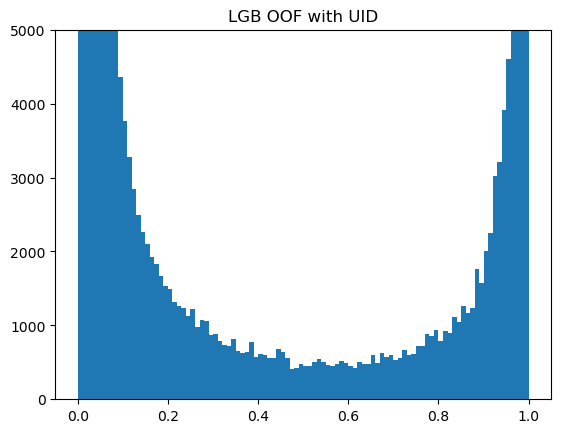

In [68]:
plt.hist(lgb_oof,bins=100)
plt.ylim((0,5000))
plt.title('LGB OOF with UID')
plt.show()

## Further improvements: Model stacking

To enhance our model's performance, we have adopted ensemble learning, a technique where we combine LGB, CatBoost, and XGBoost models into a unified ensemble. Each of these models has been evaluated individually using the cross-validation using GroupKFold method, yielding the following AUC scores:

1. LGB: 0.9522
2. CatBoost: 0.9493
3. XGBoost: 0.9514

Our goal is to leverage the strengths of these individual models by combining them strategically. To achieve this, we've implemented a weighted ensemble approach. In this approach, we assign varying weightage to each model based on their respective AUC scores. The aim is to prioritize the more accurate models, ensuring they have a more substantial influence on the final predictions.

As a result of this ensemble weighting strategy, our weighted ensemble model has experienced a notable improvement in AUC, achieving a score of 0.9544.

In [69]:
%%time

# Store out of fold predictions and test set predictions
cat_oof = np.zeros(len(X_train))
cat_preds = np.zeros(len(X_test))

# Setup cross-validation using GroupKFold method
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold', i, 'withholding month', month)
    print('Rows of train =', len(idxT), 'rows of holdout =', len(idxV))

    # Create the CatBoost classifier
    clf = cb.CatBoostClassifier(
        iterations=500,
        depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bylevel=0.4,
        eval_metric='AUC',
        early_stopping_rounds=100,
        verbose=100,
        random_state=42

    )

    # Prepare the data using the Pool object
    train_pool = Pool(
        X_train[selected_features].iloc[idxT],
        label=y_train.iloc[idxT]
    )

    val_pool = Pool(
        X_train[selected_features].iloc[idxV],
        label=y_train.iloc[idxV]
    )

    # Fit the CatBoost model
    h = clf.fit(
        train_pool,
        eval_set=val_pool
    )

    best_iteration = clf.best_iteration_  # Get the best iteration
    print("Best Iteration:", best_iteration)

    cat_oof[idxV] += clf.predict_proba(X_train[selected_features].iloc[idxV])[:, 1]
    cat_preds += clf.predict_proba(X_test[selected_features])[:, 1] / skf.n_splits
    del h, clf; x=gc.collect()

print('#' * 30)
print('CatBoost with UID out of fold cross-validation =', roc_auc_score(y_train, cat_oof))

# Calculate metrics
pred_threshold = 0.3
print(roc_auc_score(y_train, cat_oof))
# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (cat_oof >= pred_threshold).astype(int)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred)
confusion = confusion_matrix(y_train, y_pred)

# Print the evaluation metrics and confusion matrix
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#'*20,'\n')


Fold 0 withholding month 12
Rows of train = 888140 rows of holdout = 227990
0:	test: 0.9694432	best: 0.9694432 (0)	total: 509ms	remaining: 4m 14s
100:	test: 0.9923101	best: 0.9923101 (100)	total: 54.3s	remaining: 3m 34s
200:	test: 0.9938898	best: 0.9938944 (199)	total: 1m 46s	remaining: 2m 38s
300:	test: 0.9945437	best: 0.9945437 (300)	total: 2m 35s	remaining: 1m 42s
400:	test: 0.9947993	best: 0.9947993 (400)	total: 3m 24s	remaining: 50.5s
499:	test: 0.9950497	best: 0.9950547 (495)	total: 4m 13s	remaining: 0us

bestTest = 0.9950547361
bestIteration = 495

Shrink model to first 496 iterations.
Best Iteration: 495
Fold 1 withholding month 15
Rows of train = 908902 rows of holdout = 207228
0:	test: 0.9677580	best: 0.9677580 (0)	total: 476ms	remaining: 3m 57s
100:	test: 0.9933477	best: 0.9933477 (100)	total: 51.7s	remaining: 3m 24s
200:	test: 0.9950260	best: 0.9950260 (200)	total: 1m 45s	remaining: 2m 36s
300:	test: 0.9958325	best: 0.9958325 (300)	total: 2m 38s	remaining: 1m 44s
400:	test:

In [70]:
%%time 

# xgboost too slow
# Store out of fold predictions and test set predictions
xgb_oof = np.zeros(len(X_train))
xgb_preds = np.zeros(len(X_test))

# Setup cross-validation using GroupKFold method
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print('Rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = xgb.XGBClassifier(
        n_estimators=500, #5000
        max_depth=12, #12
        learning_rate=0.02, #0.02
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        early_stopping_rounds=100,
        # USE CPU
        nthread=-1,
        tree_method='hist',
        random_state=42

        # USE GPU
        #tree_method='gpu_hist' 
    )        
    h = clf.fit(X_train[selected_features].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[selected_features].iloc[idxV],y_train.iloc[idxV])],
            verbose=50)
    
    best_iteration = clf.best_iteration  # Get the best iteration
    print("Best Iteration:", best_iteration)

    xgb_oof[idxV] += clf.predict_proba(X_train[selected_features].iloc[idxV])[:,1]
    xgb_preds += clf.predict_proba(X_test[selected_features])[:,1]/skf.n_splits
    del h, clf; x=gc.collect()
print('#'*30)
print ('XGB with UID out of fold cross validation=',roc_auc_score(y_train,xgb_oof))

# Calculate metrics
pred_threshold = 0.3
print(roc_auc_score(y_train, xgb_oof))
# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (xgb_oof >= pred_threshold).astype(int)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred)
confusion = confusion_matrix(y_train, y_pred)

# Print the evaluation metrics and confusion matrix
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#'*20,'\n')

Fold 0 withholding month 12
Rows of train = 888140 rows of holdout = 227990
[0]	validation_0-auc:0.96755
[50]	validation_0-auc:0.99268
[100]	validation_0-auc:0.99364
[150]	validation_0-auc:0.99450
[200]	validation_0-auc:0.99513
[250]	validation_0-auc:0.99556
[300]	validation_0-auc:0.99582
[350]	validation_0-auc:0.99601
[400]	validation_0-auc:0.99617
[450]	validation_0-auc:0.99625
[499]	validation_0-auc:0.99626
Best Iteration: 496
Fold 1 withholding month 15
Rows of train = 908902 rows of holdout = 207228
[0]	validation_0-auc:0.97244
[50]	validation_0-auc:0.99443
[100]	validation_0-auc:0.99511
[150]	validation_0-auc:0.99582
[200]	validation_0-auc:0.99643
[250]	validation_0-auc:0.99689
[300]	validation_0-auc:0.99718
[350]	validation_0-auc:0.99739
[400]	validation_0-auc:0.99750
[450]	validation_0-auc:0.99761
[499]	validation_0-auc:0.99766
Best Iteration: 490
Fold 2 withholding month 13
Rows of train = 930236 rows of holdout = 185894
[0]	validation_0-auc:0.97147
[50]	validation_0-auc:0.994

In [71]:
# Stacking models together

lgb_auc = roc_auc_score(y_train, lgb_oof)
cat_auc = roc_auc_score(y_train, cat_oof)
xgb_auc = roc_auc_score(y_train, xgb_oof)

print('CatBoost with UID out of fold cross-validation =', cat_auc)
print('LGBM with UID out of fold cross validation =', lgb_auc)
print('XGB with UID out of fold cross validation =', xgb_auc)

# Initialize array to store ensemble predictions
ensemble_valid_preds = np.zeros(len(lgb_oof))

# Define weights for each model's predictions
weight_xgb = xgb_auc/(lgb_auc + cat_auc + xgb_auc)
weight_lightgbm = lgb_auc/(lgb_auc + cat_auc + xgb_auc)
weight_catboost = cat_auc/(lgb_auc + cat_auc + xgb_auc)

# Add weighted predictions from XGBoost
ensemble_valid_preds += weight_catboost * xgb_oof

# Add weighted predictions from LightGBM
ensemble_valid_preds += weight_lightgbm * lgb_oof

# Add weighted predictions from CatBoost
ensemble_valid_preds += weight_catboost * cat_oof

ensemble_roc_auc = roc_auc_score(y_train, ensemble_valid_preds)
print('Ensemble ROC AUC Score:', ensemble_roc_auc)

best_f1_score = 0
best_threshold = 0

for threshold in np.arange(0.1, 1.0, 0.1):
    ensemble_predictions = (ensemble_valid_preds >= threshold).astype(int)
    f1 = f1_score(y_train, ensemble_predictions)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print("\nBest F1 Score:", best_f1_score)
print("Best Threshold:", round(best_threshold,1))


# Calculate predictions for the ensemble model
ensemble_predictions = (ensemble_valid_preds >= best_threshold).astype(int)

# Calculate the confusion matrix
confusion = confusion_matrix(y_train, ensemble_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_train, ensemble_predictions)

# Calculate precision
precision = precision_score(y_train, ensemble_predictions)

# Calculate recall
recall = recall_score(y_train, ensemble_predictions)

# Calculate F1 score
f1 = f1_score(y_train, ensemble_predictions)

# Print the confusion matrix and evaluation metrics
print("\nConfusion Matrix:")
print(confusion)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

CatBoost with UID out of fold cross-validation = 0.9962434470129016
LGBM with UID out of fold cross validation = 0.996993177803426
XGB with UID out of fold cross validation = 0.9973991719885807
Ensemble ROC AUC Score: 0.9973153512681673

Best F1 Score: 0.9807200656737423
Best Threshold: 0.3

Confusion Matrix:
[[551189   6876]
 [ 14496 543569]]
Accuracy: 0.9808516929031564
Precision: 0.9875082887481946
Recall: 0.974024531192603
F1 Score: 0.9807200656737423


In [72]:
# Initialize array to store ensemble predictions
ensemble_test_preds = np.zeros(len(lgb_preds))

# Add weighted predictions from XGBoost
ensemble_test_preds += weight_catboost * xgb_preds

# Add weighted predictions from LightGBM
ensemble_test_preds += weight_lightgbm * lgb_preds

# Add weighted predictions from CatBoost
ensemble_test_preds += weight_catboost * cat_preds